## 패키지

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## 데이터

In [7]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [8]:
train.shape, test.shape

((2952, 15), (1022, 14))

### 중복 데이터 제거

In [9]:
train = train.drop_duplicates()

### 오류 데이터 보정

#### 오류 2
2. 동일한 단지에 단지코드가 2개로 부여된 경우  


 - (오류 내용) 동일한 단지임에도 불구하고 코드가 2개로 부여되어 별개의 단지로 인식되도록 데이터가 제공되었고, 그로 인해 주차면수는 2개 단지에 합산값으로 기재되었고 총세대수는 2개 단지에 각각 계상된 형태로 나타났습니다.

 - (발생 원인) 1번과 마찬가지로 분양과 임대가 혼합된 유형의 단지임으로 인해 발생한 오류이나 1번에서는 분양세대에 단지코드가 부여되지 않고 전용면적별 세대수에서 빠져있는 반면, 2번에서는 분양세대에도 단지코드가 부여되어 별개의 단지인 것처럼 인식되었습니다. 

 - (참고 사항) 주차면수는 하나의 단지임을 전제로 산정된 것이고 총세대수는 두 개 단지의 합계입니다. 다만 등록차량대수는 ['C2085', 'C1397'] 단지의 경우 동일 수치, ['C2431', 'C1649']] 단지의 경우 두 개 단지 합계입니다. 

In [10]:
arr_err2 =  [['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675']]

cnt = 0
idx_total_err = np.zeros(train.shape[0], dtype=bool)
for item in arr_err2:
    print(item[0],(train['단지코드']==item[0]).sum(),item[1],(train['단지코드']==item[1]).sum())
    idx_err = (train['단지코드'] == item[0]) | (train['단지코드'] == item[1])
    idx_total_err = idx_total_err | idx_err
    cnt += idx_err.sum()

train = train.drop(train.index[idx_total_err])
print('dropped {} data'.format(cnt))

C2085 8 C1397 6
C2431 2 C1649 4
C1036 7 C2675 0
dropped 27 data


#### 오류 3
3. 단지코드 등 기입 실수로 데이터 정제 과정에서 매칭 오류 발생  

 - (오류 내용) 단지코드 등 기입 실수로 총세대수가 주차면수에 비해 과하게 많거나 적은 경우가 발생하였고, 점검 결과 일부 데이터의 단지코드, 총세대수, 주차면수 등에서 오류가 검출되었습니다.

 - (발생 원인) 원천데이터 수집 과정에서 단지 코드 등이 잘못 기입되었고 이를 인지하지 못한 채 데이터 정제를 하여 오류가 발생하였습니다.

 - (관련 데이터) 아래와 같이 총 9개 단지에서 같은 문제가 확인되었습니다. 

In [11]:
arr_err3 = ['C2335', 'C1327', # test set
 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'] # train set

cnt = 0
idx_total_err = np.zeros(train.shape[0], dtype=bool)
for item in arr_err3:
    print(item, (train['단지코드']==item).sum())
    idx_err = train['단지코드']==item
    idx_total_err = idx_total_err | idx_err
    cnt += idx_err.sum()
train = train.drop(train.index[idx_total_err])
print('dropped {} data'.format(cnt))

C2335 0
C1327 0
C1095 8
C2051 23
C1218 3
C1894 8
C2483 8
C1502 2
C1988 4
dropped 56 data


## train/test 데이터 확인

In [12]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
8,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0
9,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0
10,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000,107130,0.0,3.0,624.0,205.0
11,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000,149760,0.0,3.0,624.0,205.0
12,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000,149760,0.0,3.0,624.0,205.0


In [13]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


## 결측치 확인

In [14]:
train.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           292
임대료                             292
도보 10분거리 내 지하철역 수(환승노선 수 반영)    151
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [15]:
test.isna().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

## 컬럼명 변경

지하쳘역 수와 버스 정류장 수의 컬럼명을 지하철, 버스로 변경하였습니다.

In [16]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')

In [17]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '신분',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

## 지역명 숫자로 매핑

In [18]:
local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i
local_map

{'경상남도': 0,
 '대전광역시': 1,
 '경기도': 2,
 '전라북도': 3,
 '강원도': 4,
 '광주광역시': 5,
 '충청남도': 6,
 '부산광역시': 7,
 '제주특별자치도': 8,
 '울산광역시': 9,
 '충청북도': 10,
 '전라남도': 11,
 '경상북도': 12,
 '대구광역시': 13,
 '서울특별시': 14,
 '세종특별자치시': 15}

In [19]:
train['지역'] = train['지역'].map(local_map)
test['지역'] = test['지역'].map(local_map)

## 임대건물구분 매핑

In [20]:
building_type = {}
for btype in train['임대건물구분'].unique():
    if btype == '아파트':
        building_type[btype] = 0
    elif btype == '상가':
        building_type[btype] = 1
building_type

{'아파트': 0, '상가': 1}

In [21]:
train['임대건물구분'] = train['임대건물구분'].map(building_type)
test['임대건물구분'] = test['임대건물구분'].map(building_type)

In [22]:
print((train['임대건물구분']==0).sum())
print((train['임대건물구분']==1).sum())
print((test['임대건물구분']==0).sum())
print((test['임대건물구분']==1).sum())

tmp = train.loc[train['임대건물구분']==1]
tmp.iloc[0:20]

2264
285
845
177


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
88,C1925,601,1,4,임대상가,32.10,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
91,C1925,601,1,4,임대상가,72.16,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
101,C1874,619,1,6,임대상가,12.62,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
102,C1874,619,1,6,임대상가,17.40,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
104,C1874,619,1,6,임대상가,22.89,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
105,C1874,619,1,6,임대상가,23.13,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
107,C1874,619,1,6,임대상가,23.25,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
108,C1874,619,1,6,임대상가,27.75,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
119,C1874,619,1,6,임대상가,28.19,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0
120,C1874,619,1,6,임대상가,34.80,1,2.0,D,NaN,NaN,NaN,2.0,97.0,62.0


## 전용면적을 5의 배수로 변경

In [23]:
train['전용면적'] = train['전용면적']//5*5
test['전용면적'] = test['전용면적']//5*5

## 전용면적 상/하한 적용

상한100, 하한 15

In [24]:
idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100
idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

thres_area_lower = 5
idx = train[train['전용면적']<thres_area_lower].index
train.loc[idx, '전용면적'] = thres_area_lower
idx = test[test['전용면적']<thres_area_lower].index
test.loc[idx, '전용면적'] = thres_area_lower

In [25]:
area_bin_tr = np.sort(train['전용면적'].unique())
area_bin_te = np.sort(test['전용면적'].unique())
print(area_bin_tr)
print(area_bin_te)

[ 10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.
  80. 100.]
[  5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  70.  75.
  80. 100.]


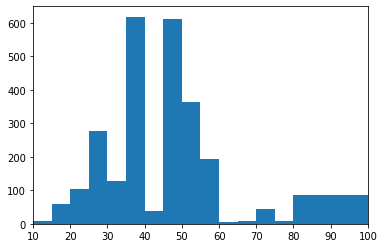

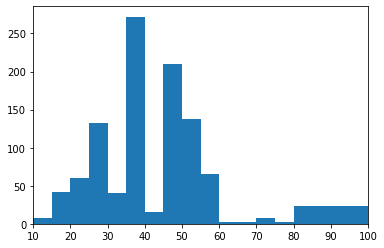

In [26]:
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(train['전용면적'],area_bin_tr)
plt.xlim(area_bin_tr[0],area_bin_tr[-1])
plt.show()
plt.hist(test['전용면적'],area_bin_te)
plt.xlim(area_bin_tr[0],area_bin_tr[-1])
plt.show()

## 단지별 데이터 1차원으로 취합

In [27]:
columns = ['단지코드', '임대건물구분', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스']
# columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스']
# columns = ['단지코드', '총세대수', '공가수', '단지내주차면수', '지하철', '버스']
target = '등록차량수'
area_columns = []
for area in area_bin_tr:
    area_columns.append(f'면적_{area}')

In [28]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [29]:
train[train['단지코드']=='C1925']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,신분,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수
86,C1925,601,0,4,영구임대,25.0,298,9.0,C,8052000,130850,0.0,4.0,117.0,75.0
87,C1925,601,0,4,영구임대,30.0,298,9.0,C,9174000,144460,0.0,4.0,117.0,75.0
88,C1925,601,1,4,임대상가,30.0,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0
91,C1925,601,1,4,임대상가,70.0,1,9.0,D,NaN,NaN,0.0,4.0,117.0,75.0


In [30]:
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0])
#     print(temp.loc[:,['단지코드','전용면적','임대건물구분']])
    
    for col in columns:
#         new_train.loc[i, col] = temp.loc[0, col]
        new_train.loc[i, col] = temp[col].iloc[-1]
#         if col=='임대건물구분':
#             print(code,col,temp.loc[0, col])
#     print(code,new_train['임대건물구분'])
    
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()

411it [00:02, 155.57it/s]
150it [00:00, 162.95it/s]


In [31]:
new_train

,단지코드,임대건물구분,총세대수,공가수,지역,단지내주차면수,지하철,버스,면적_10.0,면적_15.0,...,면적_45.0,면적_50.0,면적_55.0,면적_60.0,면적_65.0,면적_70.0,면적_75.0,면적_80.0,면적_100.0,등록차량수
0,C2515,0.0,545.0,17.0,0.0,624.0,0.0,3.0,0.0,0.0,...,57.0,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0
1,C1407,0.0,1216.0,13.0,1.0,1285.0,1.0,1.0,0.0,0.0,...,170.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1064.0
2,C1945,0.0,755.0,6.0,2.0,734.0,1.0,3.0,0.0,0.0,...,0.0,303.0,212.0,0.0,0.0,0.0,0.0,0.0,0.0,730.0
3,C1470,0.0,696.0,14.0,3.0,645.0,0.0,2.0,0.0,0.0,...,196.0,246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,553.0
4,C1898,0.0,566.0,9.0,3.0,517.0,0.0,6.0,0.0,0.0,...,209.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,415.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,C2586,0.0,90.0,7.0,8.0,66.0,0.0,3.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
407,C2035,0.0,492.0,24.0,4.0,521.0,0.0,1.0,0.0,0.0,...,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0
408,C2020,0.0,40.0,7.0,7.0,25.0,1.0,2.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
409,C2437,0.0,90.0,12.0,10.0,30.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0


## 결측치 처리

In [32]:
new_train = new_train.fillna(-1)
new_test = new_test.fillna(-1)

## Dataset configuration

### training/test set

In [33]:
x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:,-1]
x_test = new_test.iloc[:,1:]

### categorize '지역' 

In [34]:
for i in local_map.values():
    x_train['지역'+str(i)] = 0
    x_test['지역'+str(i)] = 0
    
for i in local_map.values():
    x_train.loc[x_train['지역']==i,'지역'+str(i)] = 1
    x_test.loc[x_test['지역']==i,'지역'+str(i)] = 1
    
x_train = x_train.drop(columns=['지역'])
x_test =  x_test.drop(columns=['지역'])

## 학습

### 학습 데이터 시각화

In [35]:
x_train

,임대건물구분,총세대수,공가수,단지내주차면수,지하철,버스,면적_10.0,면적_15.0,면적_20.0,면적_25.0,...,지역6,지역7,지역8,지역9,지역10,지역11,지역12,지역13,지역14,지역15
0,0.0,545.0,17.0,624.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1216.0,13.0,1285.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,755.0,6.0,734.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,696.0,14.0,645.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,566.0,9.0,517.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.0,90.0,7.0,66.0,0.0,3.0,0.0,12.0,0.0,42.0,...,0,0,1,0,0,0,0,0,0,0
407,0.0,492.0,24.0,521.0,0.0,1.0,0.0,0.0,0.0,156.0,...,0,0,0,0,0,0,0,0,0,0
408,0.0,40.0,7.0,25.0,1.0,2.0,0.0,20.0,0.0,5.0,...,0,1,0,0,0,0,0,0,0,0
409,0.0,90.0,12.0,30.0,0.0,1.0,0.0,0.0,90.0,0.0,...,0,0,0,0,1,0,0,0,0,0


(array([43., 50., 60., 64., 56., 42., 32., 22., 13.,  8.,  8.,  2.,  1.,
         4.,  3.,  1.,  0.,  0.,  1.,  1.]),
 array([  13.  ,  139.85,  266.7 ,  393.55,  520.4 ,  647.25,  774.1 ,
         900.95, 1027.8 , 1154.65, 1281.5 , 1408.35, 1535.2 , 1662.05,
        1788.9 , 1915.75, 2042.6 , 2169.45, 2296.3 , 2423.15, 2550.  ]),
 <BarContainer object of 20 artists>)

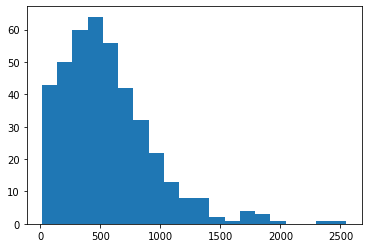

In [36]:
import matplotlib.pyplot as plt
plt.hist(y_train,20)

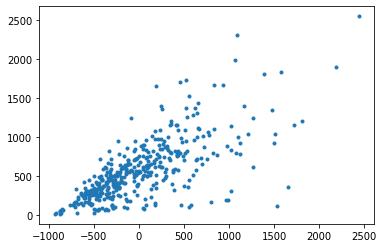

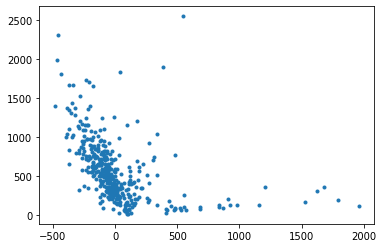

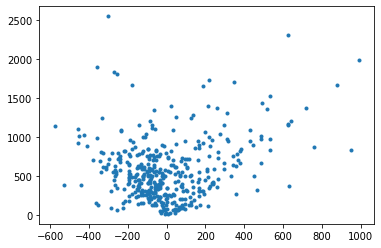

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_train = np.array(x_train)
Y_train = np.array(y_train)
pca = PCA(n_components=3)
X = pca.fit_transform(X_train)
plt.plot(X[:,0],Y_train,'.')
plt.show()
plt.plot(X[:,1],Y_train,'.')
plt.show()
plt.plot(X[:,2],Y_train,'.')
plt.show()

# MAE function

In [38]:
def print_mae_cv(model):
    model.fit(x_train_cvtr,y_train_cvtr)
    y_hat_cvte = model.predict(x_train_cvte)
    mae = (y_hat_cvte-y_train_cvte).abs().mean()
    print(mae)
    
def print_mae(model):
    model.fit(x_train,y_train)
    y_hat = model.predict(x_train)
    mae = (y_hat-y_train).abs().mean()
    print(mae)

## configure cross-validation

In [39]:
k_fold = 4
n_test = int(x_train.shape[0]/k_fold)
idx_total = np.random.permutation(x_train.shape[0])
idx_train = idx_total[n_test:]
idx_test  = idx_total[:n_test]
# x_train[idx_train]

In [40]:
x_train_cvtr = x_train.iloc[idx_train,:]
y_train_cvtr = y_train.iloc[idx_train]
x_train_cvte = x_train.iloc[idx_test,:]
y_train_cvte = y_train.iloc[idx_test]

### Random Forest (baseline)

In [41]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)
print_mae_cv(model)
print_mae(model)

134.95960784313726
46.48364963503649


### Linear regression

In [42]:
model = LinearRegression(normalize = True)
print_mae_cv(model)
print_mae(model)

120.22916666666667
103.51277372262774


C:\Users\JiWoong Jeon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\JiWoong Jeon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the

### Lasso regression

In [43]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=1,normalize=True)
print_mae_cv(model)
print_mae(model)

120.29128619957693
116.77782187620141


C:\Users\JiWoong Jeon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\JiWoong Jeon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a Standar

### RANSAC regression

In [44]:
from sklearn.linear_model import RANSACRegressor
model = RANSACRegressor()
print_mae_cv(model)
print_mae(model)

153.4311227762556
989372355358.7257


### Theilsen regression

In [45]:
from sklearn.linear_model import TheilSenRegressor
model = TheilSenRegressor()
print_mae_cv(model)
print_mae(model)

125.96236070159209
155.15876704475232


### HuberRegressor

In [46]:
from sklearn.linear_model import HuberRegressor
model = HuberRegressor(max_iter=1e9, )
print_mae_cv(model)
print_mae(model)
print(model.score(x_train,y_train))

112.08644354294152
98.93080103939087
0.8455138236424528


In [49]:
from sklearn.linear_model import HuberRegressor
model = HuberRegressor(max_iter=100, )
print_mae_cv(model)
print_mae(model)
print(model.score(x_train,y_train))

108.60140268673885
108.21663110054911
0.8062633698872104


C:\Users\JiWoong Jeon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\JiWoong Jeon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Visualize prediction vs ground truth

In [50]:
model.fit(x_train_cvtr,y_train_cvtr)
y_hat_cvte = model.predict(x_train_cvte)
mae = (y_hat_cvte-y_train_cvte).abs().mean()
print(model, mae)

HuberRegressor() 108.60140268673885


C:\Users\JiWoong Jeon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


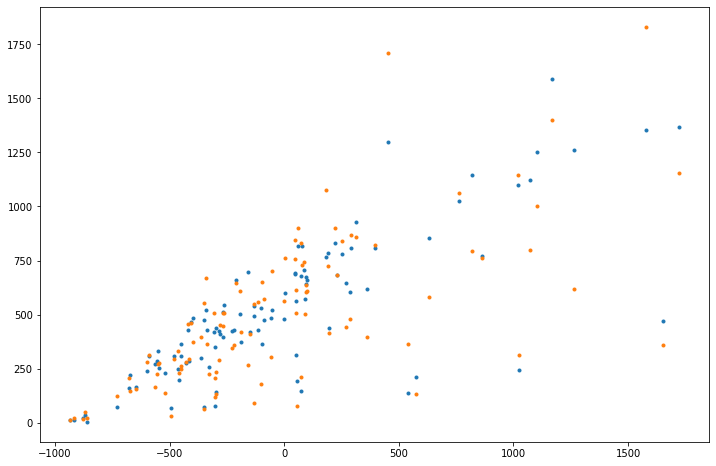

In [51]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(X[idx_test,0], y_hat_cvte,'.')
plt.plot(X[idx_test,0], y_train_cvte,'.')

# Training results

In [52]:
# model = LinearRegression(normalize = True)
model.fit(x_train,y_train)
y_hat = model.predict(x_train)
mae = (y_hat-y_train).abs().mean()
print(model)
print(mae)
print(model.score(x_train,y_train))

HuberRegressor()
108.21663110054911
0.8062633698872104


C:\Users\JiWoong Jeon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


임대건물구분


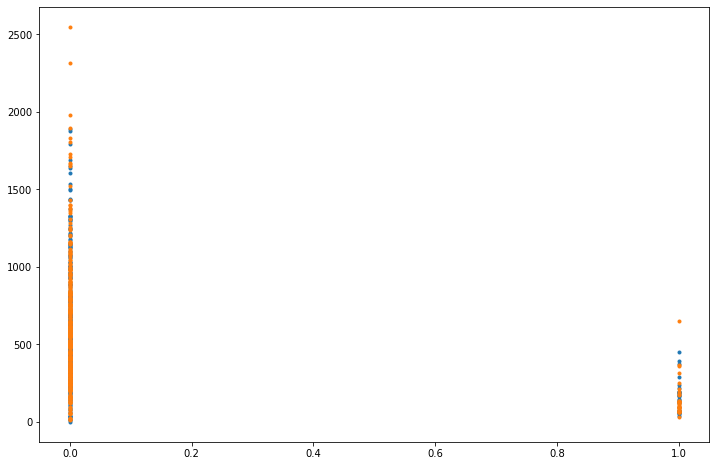

In [53]:
plt.rcParams["figure.figsize"] = (12,8)
ft_idx = 0
print(x_train.columns[ft_idx])
plt.plot(x_train.iloc[:,ft_idx], y_hat,'.')
plt.plot(x_train.iloc[:,ft_idx], y_train,'.')

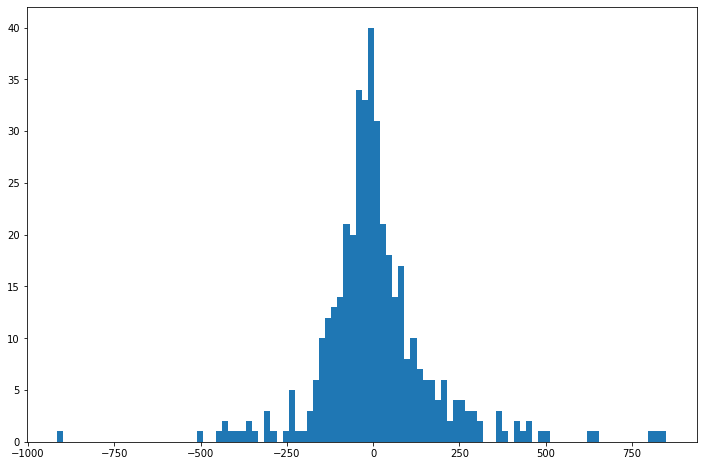

In [54]:
error = (y_hat-y_train)
I = np.argsort(error)
plt.hist(error,100)
plt.show()

In [55]:
I = np.argsort(error.abs())[::-1]
x_train.iloc[I]
# np.vstack(np.array(y_train.iloc[I]),y_hat[I])
# np.hstack((np.array(y_train.iloc[I])[:,np.newaxis],y_hat[I][:,np.newaxis]))


,임대건물구분,총세대수,공가수,단지내주차면수,지하철,버스,면적_10.0,면적_15.0,면적_20.0,면적_25.0,...,지역6,지역7,지역8,지역9,지역10,지역11,지역12,지역13,지역14,지역15
342,0.0,2568.0,11.0,1798.0,0.0,6.0,0.0,0.0,86.0,1204.0,...,0,0,0,0,0,0,0,0,0,0
56,0.0,1533.0,32.0,1296.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
27,0.0,946.0,6.0,986.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
64,0.0,1144.0,16.0,950.0,-1.0,8.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
386,0.0,1509.0,46.0,1055.0,0.0,2.0,0.0,0.0,392.0,490.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.0,924.0,13.0,986.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
142,0.0,630.0,28.0,637.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
266,0.0,992.0,36.0,871.0,0.0,15.0,0.0,0.0,0.0,160.0,...,0,0,0,0,0,0,0,0,0,0
335,0.0,1454.0,4.0,880.0,0.0,4.0,0.0,0.0,238.0,701.0,...,0,0,0,0,0,0,0,0,0,0


임대건물구분


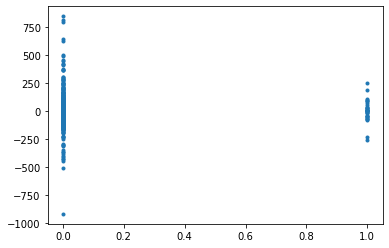

총세대수


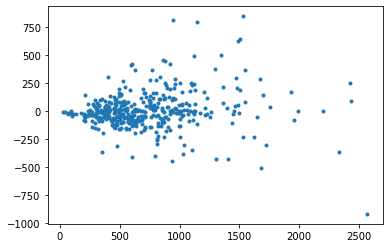

공가수


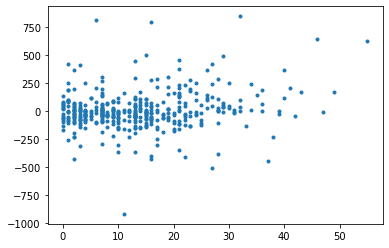

단지내주차면수


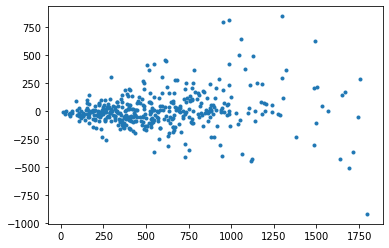

지하철


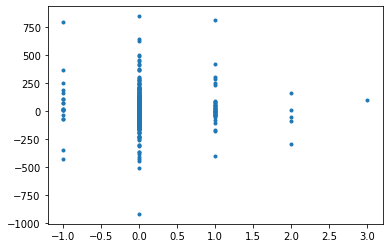

버스


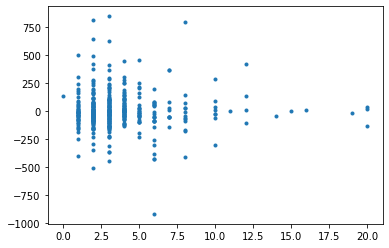

면적_10.0


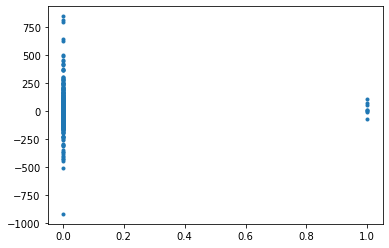

면적_15.0


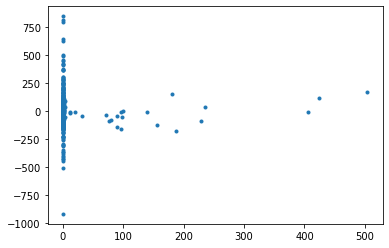

면적_20.0


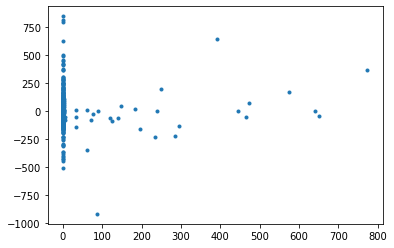

면적_25.0


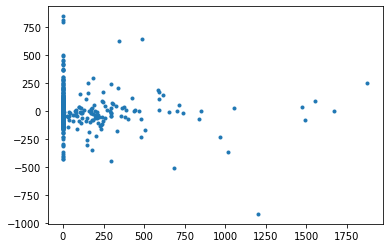

면적_30.0


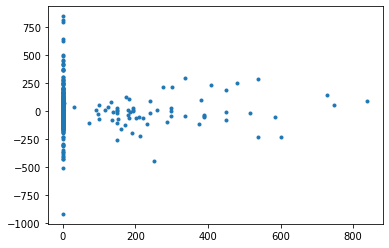

면적_35.0


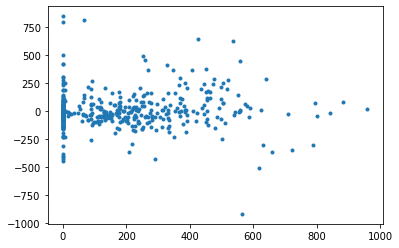

면적_40.0


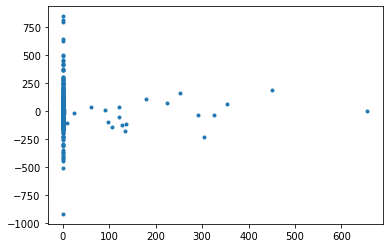

면적_45.0


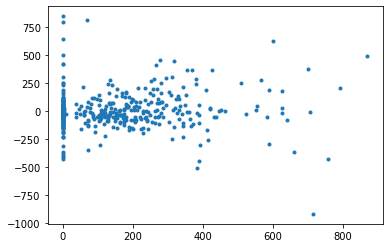

면적_50.0


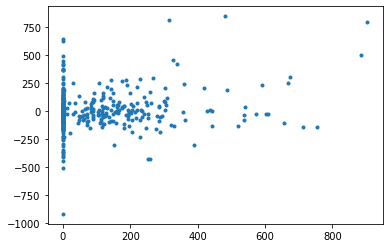

면적_55.0


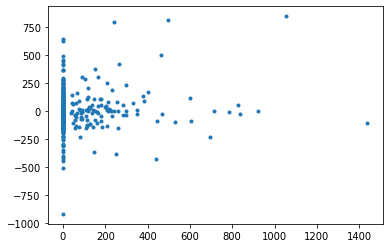

면적_60.0


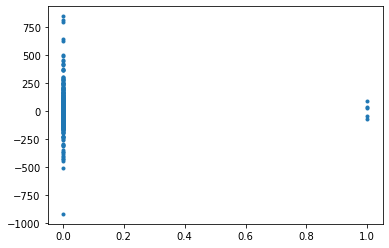

면적_65.0


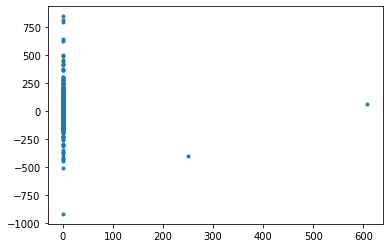

면적_70.0


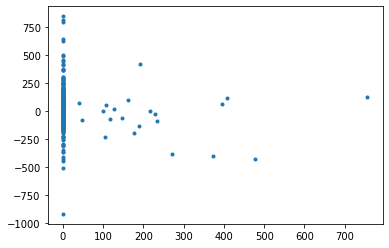

면적_75.0


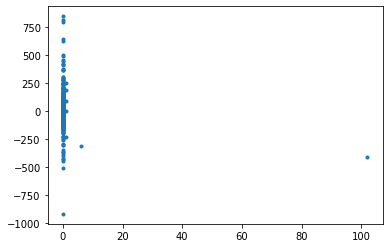

면적_80.0


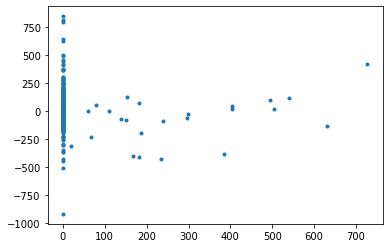

면적_100.0


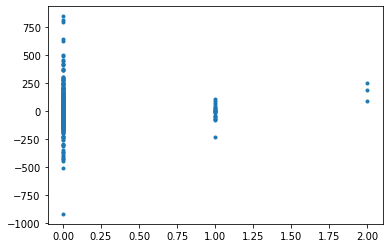

지역0


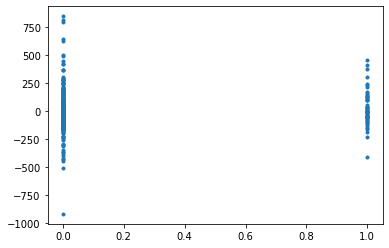

지역1


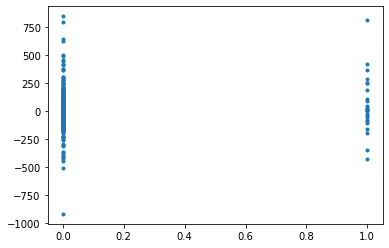

지역2


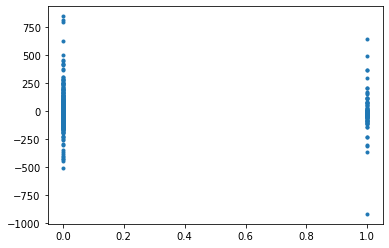

지역3


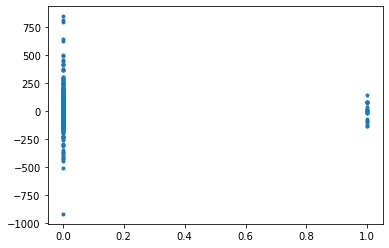

지역4


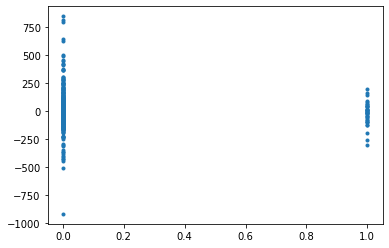

지역5


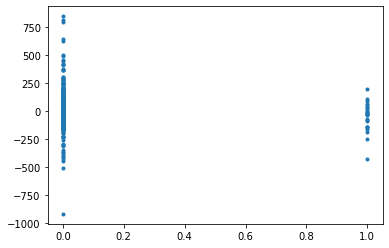

지역6


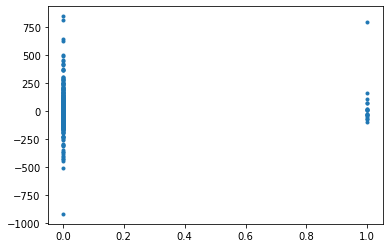

지역7


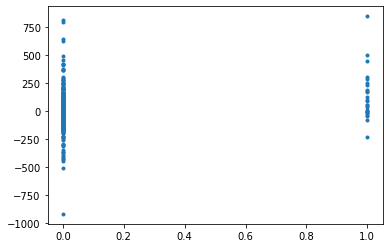

지역8


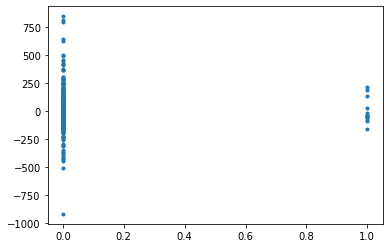

지역9


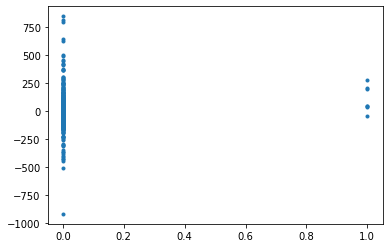

지역10


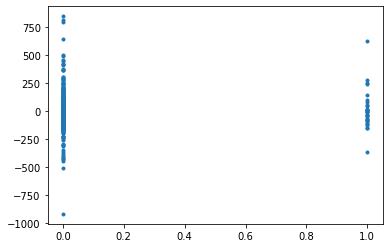

지역11


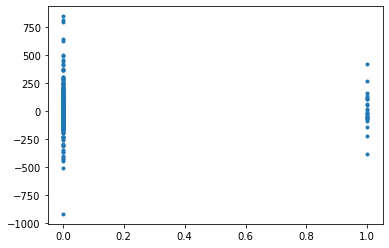

지역12


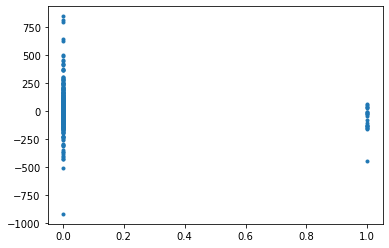

In [56]:
plt.rcParams["figure.figsize"] = (6,4)
for i in range(35):
#     plt.hist(x_train.iloc[I,i],20)
#     plt.xlabel(x_train.columns[i])
    print(x_train.columns[i])
    plt.plot(x_train.iloc[I,i],error[I],'.')
    plt.show()

## 추론 및 제출

In [57]:
print(model)
pred = model.predict(x_test)
submission['num'] = pred
submission.to_csv('baseline2.csv', index=False)

HuberRegressor()
